In [43]:
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tf2crf import CRF, ModelWithCRFLoss
import preprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
static_df, formal_df = preprocess.fetch_preprocessed_data()
print(static_df.shape)
print(formal_df.shape)
df = pd.concat([static_df, formal_df], ignore_index=True)
print(df.shape)
df

(21891, 4)
(3136, 4)
(25027, 4)


,words,tags,candidate,label
0,"[anyway, ,, thanks, mkm, and, keep, up, the, g...","[O, O, O, O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-I...",keep up the good work,1
1,"[well, done, steffi, —, keep, up, the, good, w...","[O, O, O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-IDIO...",keep up the good work,1
2,"[please, use, it, as, a, reminder, to, ensure,...","[O, O, O, O, O, O, O, O, O, O, B-IDIOM, I-IDIO...",keep up the good work,1
3,"[please, do, keep, up, the, good, work, .]","[O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-IDIOM, I-I...",keep up the good work,1
4,"[we, hope, you, find, the, current, issue, sti...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I...",keep up the good work,1
...,...,...,...,...
25022,"[this, year, marked, the, completion, and, ope...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",quantum leap,1
25023,"[a, quantum, leap, ahead, of, grace, bros, ', ...","[O, B-IDIOM, I-IDIOM, O, O, O, O, O, O, O, O, ...",quantum leap,1
25024,"[anybody, see, erm, quantum, leap, last, night...","[O, O, O, B-IDIOM, I-IDIOM, O, O, O]",quantum leap,1
25025,"[quantum, leap, in, microscopy]","[B-IDIOM, I-IDIOM, O, O]",quantum leap,1


In [45]:
df['sentence_length'] = df['words'].apply(len)

# Find the maximum sentence length
max_sentence_length = df['sentence_length'].max()

print("Maximum sentence length:", max_sentence_length)

Maximum sentence length: 751


In [46]:
longest_sentences = df[df['sentence_length'] == max_sentence_length]['words']
print(" ".join(longest_sentences[14552]))

yeah , well let me just read you two or three verses from exodus , chapter forty , this is what it says then the cloud covered the tent of meeting and the glory of the lord filled the tabernacle and moses was not able to enter the tent of meeting because the cloud had settled on it and the glory of the lord filled the tabernacle and throughout all their journeys whenever the cloud was taken up from over the tabernacle the sons of israel would set out , but if the cloud was not taken up then they did not set out until the day that it was taken up , for throughout all their journeys the cloud of the lord was on the tabernacle by day and there was fire in it by night , in the sight of all the house in israel and if you were to turn over to kings you have got a , you have got a similar thing there with the dedication of the temple and as be ben was saying the power really it 's the it 's the presence of god , the shine , the glory , that cloud of , and so what , what , what catches the lor

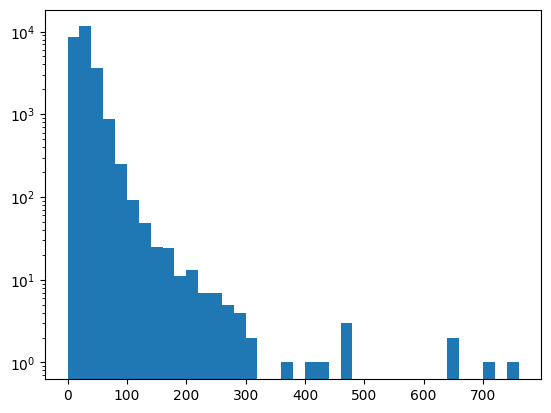

In [48]:
binwidth = 20
plt.hist(df['sentence_length'], bins=np.arange(0, df['sentence_length'].max() + binwidth, binwidth))
plt.yscale("log")

In [53]:
print(np.percentile(df['sentence_length'], 90))
print(np.percentile(df['sentence_length'], 95))
print(np.percentile(df['sentence_length'], 98))
print(np.percentile(df['sentence_length'], 99))

50.0
61.0
79.0
99.0


In [35]:
df.sort_values(by='sentence_length', ascending=False).head(20)[["sentence_length", "words"]]


,sentence_length,words
14552,751,"[yeah, ,, well, let, me, just, read, you, two,..."
18205,710,"[the, letter, from, the, plaintiffs, solicitor..."
1818,641,"[you, make, your, sound, and, you, carry, on, ..."
1773,641,"[you, make, your, sound, and, you, carry, on, ..."
23280,468,"[a, word, gets, around, the, famine, is, over,..."
20733,468,"[nao, naomi, realizes, there, 's, no, point, t..."
13059,468,"[nao, naomi, realizes, there, 's, no, point, t..."
13010,422,"[if, that, power, was, sufficient, ,, the, hol..."
5187,410,"[well, my, pal, and, myself, we, took, these, ..."
15795,375,"[she, said, it, was, br, it, was, ,, i, did, n..."


In [55]:
for i, row in df.sort_values(by='sentence_length', ascending=False).head(20)[["sentence_length", "words"]].iterrows():
    sentence_length, words = row
    print(f"- {sentence_length}: {' '.join(words[:100])}...")

- 751: yeah , well let me just read you two or three verses from exodus , chapter forty , this is what it says then the cloud covered the tent of meeting and the glory of the lord filled the tabernacle and moses was not able to enter the tent of meeting because the cloud had settled on it and the glory of the lord filled the tabernacle and throughout all their journeys whenever the cloud was taken up from over the tabernacle the sons of israel would set out , but if the cloud was not taken up then they...
- 710: the letter from the plaintiffs solicitors in respect of question of interest one causes , the letter of the twenty ninth of january of nineteen ninety two , asking mr to confirm , that in addition to the settlement figure of forty two thousand pounds in respect of costs he 'd be paying interest until the date of payment , and er , there was never a mind that erm which find a reply to in , in thirtieth of march nineteen ninety two by mr , there 's no unqualified agreement in fig

In [58]:
for i, row in df.sample(n=10)[["sentence_length", "words"]].iterrows():
    sentence_length, words = row
    print(f"- {sentence_length}: {' '.join(words[:100])}")


- 47: an across the board budgetary cut of 10 per cent for all state departments was proposed ; there was to be a freeze on the hiring of state employees , a large reduction in the staffing of state mental hospitals and various other cost cutting measures .
- 12: whatever you do do not make a mess on the table ,
- 20: one of the reasons being put forward is that they are jumping on a bandwagon which unfortunately is worldwide .
- 20: he shouted at me so i sat under the table and waited for him to put some food down .
- 17: his life seemed stuck in limbo with no sex and , worse still , no admiration .
- 27: grant watched them go , chatting amiably and swapping friendly banter as they went , easing their inner tensions as they moved nearer to zero hour .
- 13: ‘ once , ’ said burden thoughtfully , ‘ is fair enough .
- 18: it is business as usual — and the ec 's ambitious plans for monetary union are unaffected .
- 6: he just kicked the bucket .
- 16: they say an ulsterman calls a spade a

The longest sentences in the dataset seem to be speech transcriptions that are missing punctuation between sentences, so they are actually not single sentences, but paragraphs / collections of sentences. Therefore, these sentences can be considered mostly noise and might hurt the performance of the model. In comparison, the random sample of sentences from the dataset appears to be much closer to what one would expect. Including the longest "sentences" in the dataset for the purposes of training the model would increase the encoded size of each input sample substantially, since the vectorized form of each sample will be padded to the length of the maximum sentence, which would drastically increase computational load. For these reasons, we will truncate the longest sentences to 100 words, which is at the 99th percentile of sentence lengths.

In [49]:
df["tags"]

0        [O, O, O, O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-I...
1        [O, O, O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-IDIO...
2        [O, O, O, O, O, O, O, O, O, O, B-IDIOM, I-IDIO...
3        [O, O, B-IDIOM, I-IDIOM, I-IDIOM, I-IDIOM, I-I...
4        [O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-I...
                               ...                        
25022    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
25023    [O, B-IDIOM, I-IDIOM, O, O, O, O, O, O, O, O, ...
25024                 [O, O, O, B-IDIOM, I-IDIOM, O, O, O]
25025                             [B-IDIOM, I-IDIOM, O, O]
25026    [B-IDIOM, I-IDIOM, O, O, O, O, O, O, O, O, O, ...
Name: tags, Length: 25027, dtype: object

In [59]:
df['text'] = df['words'].apply(lambda x: ' '.join(x))

In [ ]:
max_len = 100

# Tokenize the words
word_tokenizer = Tokenizer(lower=False)
word_tokenizer.fit_on_texts(df['text'])
X = word_tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=max_len, padding='post')

# Tokenize the tags
tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(df['tags'])
y = tag_tokenizer.texts_to_sequences(df['tags'])
y = pad_sequences(y, maxlen=max_len, padding='post')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model architecture
input = Input(shape=(max_len,))
model = Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag_tokenizer.word_index) + 1)  # CRF layer
out = crf(model)  # output

model = ModelWithCRFLoss(Model(input, out))

# Compile the model
model.compile(optimizer="adam", loss=model.loss, metrics=[model.accuracy])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1, verbose=1)

# Evaluate the model
pred_test = model.predict(X_test)